### 8.1 Creating a toy multi-class dataset

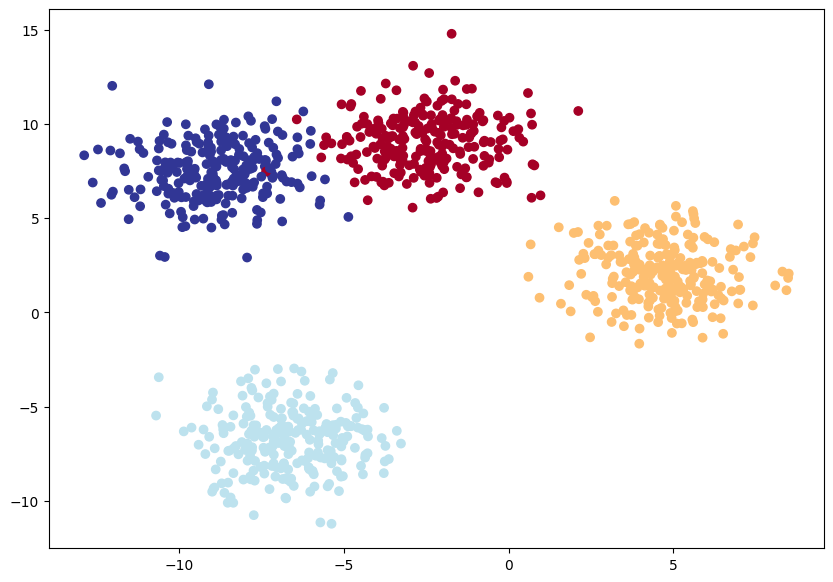

In [2]:
# Import dependencies
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

# Set the hyperparameters for data creation
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

# 1. Create multi-class data
X_blob, y_blob = make_blobs(n_samples=1000,
                            n_features=NUM_FEATURES,
                            centers=NUM_CLASSES,
                            cluster_std=1.5, # give the clusters a little shake up
                            random_state=RANDOM_SEED)

# 2. Turn data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)

# 3. Split into train and test
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,
                                                                        y_blob,
                                                                        test_size=0.2,
                                                                        random_state=RANDOM_SEED)

# 4. Plot data (Visualize, visualize, visualize)
plt.figure(figsize=(10, 7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu)

### 8.2 Building a multi-class classification model in PyTorch

In [3]:
# Create device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [4]:
# Build a multi-class classification model
class BlobModel(nn.Module):
  def __init__(self, input_features, output_features, hidden_units=8):
    """Initialize multi-class classification model.

    Args:
      input features (int): Number of input features to the model
      output features (int): Number of outputs features (number of output classes)
      hidden_units (int): Number of hidden units between layers, default 8

    Returns:

    Example:
    """
    super().__init__()
    self.linear_layer_stack = nn.Sequential(
        nn.Linear(in_features=input_features, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=output_features)
    )

  def forward(self, x):
    return self.linear_layer_stack(x)

  # Create an instance of BlobModel and send it to the target device
model = BlobModel(input_features=2,
                  output_features=4,
                  hidden_units=8)

model.to(device)



BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [5]:
X_blob_train.shape, y_blob_train[:5]

(torch.Size([800, 2]), tensor([1, 0, 2, 2, 0]))

In [6]:
torch.unique(y_blob_train)

tensor([0, 1, 2, 3])

### 8.3 Create a loss function and an optimzer for a multi-class classification model

In [7]:
# Create a loss function for multi-class classification
loss_fn = nn.CrossEntropyLoss()

# Create an optimizer for multi-class classification
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.1)


In [8]:
# Calculate accuracy
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct/len(y_pred)) * 100
  return acc

### 8.4 Getting prediction probabilities for a multi-class PyTorch Model

In order to evaluate and train and test our model, we need to convert our model's output (logits) to prediction probabilities and then to prediction labels.

Logits (raw output of the model) -> Preb probs (use `torch.softmax`) -> Preb labels (take the argmax of the prediction probabilities)

In [9]:
# Let's get some raw outputs of our model (logits)
model.eval()
with torch.inference_mode():
  y_logits = model(X_blob_test.to(device))
y_logits[:10]

tensor([[-1.1347,  0.0223,  0.0904,  0.3920],
        [-2.0244,  0.3620, -0.1482,  0.3695],
        [ 0.0532, -0.3176, -0.0925, -0.2826],
        [-0.3378, -0.1131,  0.0536, -0.1508],
        [-2.4407,  0.4417,  0.1453,  0.8452],
        [-2.3580,  0.4765, -0.1671,  0.4465],
        [ 0.1593, -0.3008, -0.0654, -0.3730],
        [-2.2546,  0.4129,  0.0580,  0.6693],
        [-0.1449, -0.3287, -0.0799, -0.1381],
        [-2.2759,  0.4088,  0.0861,  0.7152]], device='cuda:0')

In [10]:
# Convert out model's logit outputs to prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1)
print(y_logits[:5])
print(y_pred_probs[:5])

tensor([[-1.1347,  0.0223,  0.0904,  0.3920],
        [-2.0244,  0.3620, -0.1482,  0.3695],
        [ 0.0532, -0.3176, -0.0925, -0.2826],
        [-0.3378, -0.1131,  0.0536, -0.1508],
        [-2.4407,  0.4417,  0.1453,  0.8452]], device='cuda:0')
tensor([[0.0820, 0.2609, 0.2793, 0.3777],
        [0.0341, 0.3704, 0.2224, 0.3732],
        [0.3059, 0.2111, 0.2644, 0.2186],
        [0.2026, 0.2536, 0.2996, 0.2442],
        [0.0170, 0.3034, 0.2255, 0.4541]], device='cuda:0')


In [11]:
# Convert our model's prediction probabilities to prediction labels
y_preds = torch.argmax(y_pred_probs, dim=1)
y_preds

tensor([3, 3, 0, 2, 3, 1, 0, 3, 2, 3, 3, 3, 3, 3, 3, 3, 1, 0, 3, 1, 3, 3, 2, 0,
        0, 2, 1, 3, 3, 3, 3, 3, 2, 1, 3, 0, 2, 1, 3, 0, 3, 1, 1, 0, 3, 3, 3, 3,
        3, 3, 2, 3, 3, 2, 1, 0, 2, 2, 1, 0, 2, 3, 1, 2, 0, 3, 3, 3, 1, 3, 3, 3,
        1, 3, 0, 3, 1, 3, 3, 2, 3, 0, 3, 2, 1, 1, 0, 1, 1, 0, 3, 3, 2, 1, 1, 1,
        2, 3, 3, 0, 3, 3, 3, 3, 0, 3, 2, 3, 3, 0, 2, 2, 3, 0, 0, 3, 3, 3, 2, 2,
        0, 1, 3, 2, 0, 3, 3, 3, 0, 1, 3, 0, 3, 0, 3, 3, 3, 3, 3, 2, 3, 3, 0, 2,
        0, 2, 3, 3, 3, 2, 0, 3, 1, 2, 3, 3, 3, 3, 0, 3, 0, 3, 3, 0, 3, 1, 0, 3,
        0, 0, 0, 3, 3, 2, 3, 3, 2, 2, 1, 3, 3, 0, 0, 3, 0, 0, 3, 3, 0, 0, 3, 3,
        2, 1, 0, 3, 1, 2, 2, 3], device='cuda:0')

In [12]:
y_blob_test

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0, 0, 1, 0, 0, 0, 3, 3, 2, 3, 3, 3, 0, 1, 2,
        2, 2, 3, 0, 1, 0, 3, 1, 1, 3, 1, 2, 1, 3, 0, 2, 0, 3, 3, 2, 0, 3, 1, 1,
        0, 3, 1, 0, 1, 1, 3, 2, 1, 1, 3, 2, 2, 0, 3, 2, 2, 0, 0, 3, 3, 0, 0, 3,
        3, 3, 2, 3, 3, 3, 3, 1, 0, 2, 3, 2, 3, 3, 2, 3, 3, 2, 3, 3, 1, 3, 3, 3,
        1, 0, 3, 2, 0, 0, 3, 0, 2, 3, 1, 0, 3, 2, 1, 1, 0, 2, 2, 3, 0, 0, 1, 2,
        2, 3, 0, 1, 2, 0, 0, 0, 2, 3, 1, 2, 3, 2, 0, 3, 0, 0, 1, 1, 1, 0, 2, 2,
        2, 2, 0, 3, 3, 2, 2, 1, 3, 2, 0, 0, 3, 3, 2, 1, 2, 0, 3, 2, 0, 3, 2, 0,
        2, 2, 2, 0, 3, 1, 1, 1, 1, 1, 3, 1, 0, 2, 2, 1, 2, 2, 0, 1, 2, 2, 0, 0,
        1, 3, 2, 0, 3, 1, 2, 1])

### 8.5 Creating a training loop and testing loop for a multi-class PyTorch model

In [13]:
# Fit the multi-class model to the data
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)

# Set the number of epochs
epochs = 100

# Put data to the target device
X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

# Loop through data
for epoch in range(epochs):
  ### Training
  model.train()

  y_logits = model(X_blob_train)
  y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)

  loss = loss_fn(y_logits, y_blob_train)
  acc = accuracy_fn(y_true=y_blob_train, y_pred=y_pred)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  ### Testing
  model.eval()
  with torch.inference_mode():
    test_logits = model(X_blob_test)
    test_preds = torch.softmax(test_logits, dim=1).argmax(dim=1)

    test_loss = loss_fn(test_logits, y_blob_test)
    test_acc = accuracy_fn(y_true=y_blob_test, y_pred=test_preds)


  # Print out what's happenin
  if epoch % 10 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.4f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.4f} Test Acc: {test_acc:.2f}%")


Epoch: 0 | Loss: 1.8765, Acc: 16.38% | Test Loss: 1.3148 Test Acc: 43.50%
Epoch: 10 | Loss: 0.6434, Acc: 97.00% | Test Loss: 0.5721 Test Acc: 99.50%
Epoch: 20 | Loss: 0.2166, Acc: 99.25% | Test Loss: 0.1871 Test Acc: 99.50%
Epoch: 30 | Loss: 0.0912, Acc: 99.25% | Test Loss: 0.0787 Test Acc: 99.50%
Epoch: 40 | Loss: 0.0603, Acc: 99.25% | Test Loss: 0.0503 Test Acc: 99.50%
Epoch: 50 | Loss: 0.0475, Acc: 99.25% | Test Loss: 0.0382 Test Acc: 99.50%
Epoch: 60 | Loss: 0.0408, Acc: 99.25% | Test Loss: 0.0315 Test Acc: 99.50%
Epoch: 70 | Loss: 0.0366, Acc: 99.25% | Test Loss: 0.0273 Test Acc: 99.50%
Epoch: 80 | Loss: 0.0338, Acc: 99.38% | Test Loss: 0.0245 Test Acc: 99.50%
Epoch: 90 | Loss: 0.0319, Acc: 99.38% | Test Loss: 0.0224 Test Acc: 99.50%


### 8.6 Making and evaluating predictions with a PyTorch multi-class model

In [14]:
# Make predictions
model.eval()
with torch.inference_mode():
  y_logits = model(X_blob_test)

# View the first 10 predictions
y_logits[:10]


tensor([[-9.3465e-01,  5.9693e+00, -2.3701e+00, -3.0828e+00],
        [-3.5527e-01, -4.3751e+00, -2.3605e+00,  4.9290e+00],
        [-5.3510e+00, -1.7717e+00,  5.8117e+00,  5.1746e-01],
        [-1.7947e+00,  4.4199e+00, -6.9827e-01, -2.4087e+00],
        [ 6.5556e+00,  6.9407e-01, -6.5374e+00, -9.4703e-01],
        [-7.5010e-01, -5.2580e+00, -2.3904e+00,  5.9639e+00],
        [-4.4463e+00, -1.5094e+00,  4.8543e+00,  3.3310e-01],
        [ 6.5832e+00, -1.3074e+00, -6.4442e+00,  5.8635e-01],
        [-6.9871e+00, -2.2462e+00,  7.5426e+00,  8.5140e-01],
        [ 6.5102e+00, -6.0772e-01, -6.3481e+00, -1.6767e-04]], device='cuda:0')

In [15]:
# Go from logits -> Prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1)
y_pred_probs[:10]

tensor([[1.0025e-03, 9.9864e-01, 2.3861e-04, 1.1699e-04],
        [5.0412e-03, 9.0517e-05, 6.7872e-04, 9.9419e-01],
        [1.4117e-05, 5.0601e-04, 9.9449e-01, 4.9928e-03],
        [1.9819e-03, 9.9101e-01, 5.9330e-03, 1.0726e-03],
        [9.9661e-01, 2.8373e-03, 2.0526e-06, 5.4977e-04],
        [1.2120e-03, 1.3359e-05, 2.3505e-04, 9.9854e-01],
        [9.0228e-05, 1.7014e-03, 9.8747e-01, 1.0740e-02],
        [9.9715e-01, 3.7319e-04, 2.1931e-06, 2.4795e-03],
        [4.8891e-07, 5.6000e-05, 9.9870e-01, 1.2401e-03],
        [9.9770e-01, 8.0860e-04, 2.5985e-06, 1.4845e-03]], device='cuda:0')

In [16]:
# Go from pred pros to pred labesl
y_preds = torch.argmax(y_pred_probs, dim=1)
y_preds[:10]

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0], device='cuda:0')

In [17]:
import requests
from pathlib import Path

# Download helper function from Learn PyTorch repo (if it's not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exist, skipping download")
else:
  print("Download helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

helper_functions.py already exist, skipping download


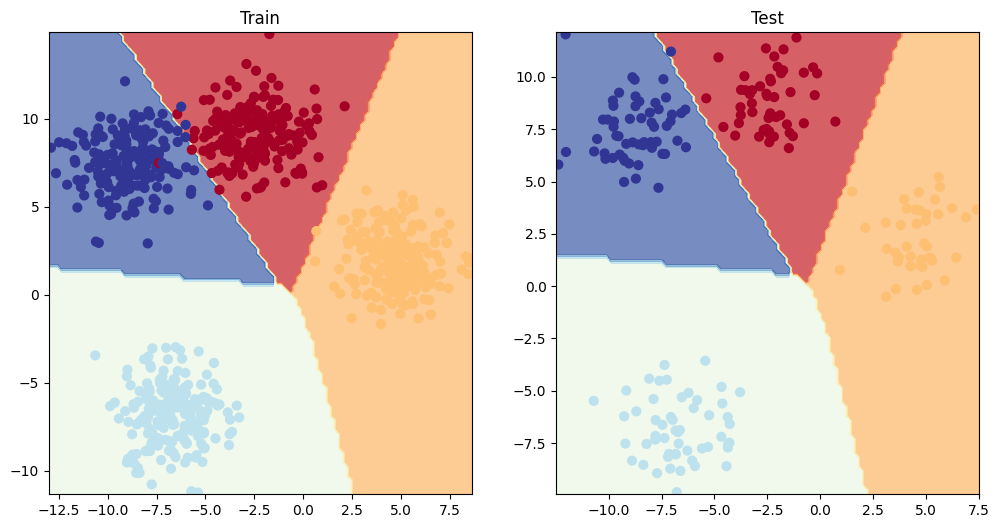

In [18]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model, X_blob_train, y_blob_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model, X_blob_test, y_blob_test)

## 9. A few more classification metrics... (to evaluate our classification model)

* Accuracy - out of 100 samples, how many does our model get right?
* Precision
* Recall
* F1-score
* Confusion matrix
* Classification report

In [19]:
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.2/840.2 kB 7.9 MB/s eta 0:00:00


In [23]:
from torchmetrics import Accuracy

# setup metric
torchmetric_accuracy = Accuracy("multiclass", num_classes=NUM_CLASSES).to(device)

# Calculate accuracy
torchmetric_accuracy(y_preds, y_blob_test)


tensor(0.9950, device='cuda:0')